In [1]:
!pip install dionysus

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for dionysus: filename=dionysus-2.0.10-cp310-cp310-linux_x86_64.whl size=440651 sha256=ab402ca5e6e1f65b8fddb3ce146abfdeba605cd9b25d3f49905b088667513501
  Stored in directory: /root/.cache/pip/wheels/1d/8f/2a/22f69fac8dab81069f0501bdd69961a69e82b8b3007f191a15
Successfully built dionysus


In [2]:
!pip install POT
!pip install gudhi
!pip install importlib-metadata==4.13.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 702.9/702.9 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 8.8 MB/s eta 0:00:00
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.6.4
    Uninstalling importlib-metadata-4.6.4:
      Successfully uninstalled importlib-metadata-4.6.4


In [3]:
import numpy as np
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import ot
import dionysus as d
from gudhi.wasserstein import wasserstein_distance as wd
from sklearn.cluster import KMeans

In [4]:
from numpy import linalg as LA

In [5]:
def make_point_clouds(n_samples_per_shape: int, n_points: int, noise: float):
    """Make point clouds for circles, spheres, and tori with random noise.
    """
    circle_point_clouds = [
        np.asarray(
            [
                [np.sin(t) + noise * (np.random.rand(1)[0] - 0.5), np.cos(t) + noise * (np.random.rand(1)[0] - 0.5), 0]
                for t in range((n_points ** 2))
            ]
        )
        for kk in range(n_samples_per_shape)
    ]
    # label circles with 0
    circle_labels = np.zeros(n_samples_per_shape)

    sphere_point_clouds = [
        np.asarray(
            [
                [
                    np.cos(s) * np.cos(t) + noise * (np.random.rand(1)[0] - 0.5),
                    np.cos(s) * np.sin(t) + noise * (np.random.rand(1)[0] - 0.5),
                    np.sin(s) + noise * (np.random.rand(1)[0] - 0.5),
                    ]
                for t in range(n_points)
                for s in range(n_points)
            ]
        )
        for kk in range(n_samples_per_shape)
    ]
    # label spheres with 1
    sphere_labels = np.ones(n_samples_per_shape)

    torus_point_clouds = [
        np.asarray(
            [
                [
                    (2 + np.cos(s)) * np.cos(t) + noise * (np.random.rand(1)[0] - 0.5),
                    (2 + np.cos(s)) * np.sin(t) + noise * (np.random.rand(1)[0] - 0.5),
                    np.sin(s) + noise * (np.random.rand(1)[0] - 0.5),
                    ]
                for t in range(n_points)
                for s in range(n_points)
            ]
        )
        for kk in range(n_samples_per_shape)
    ]
    # label tori with 2
    torus_labels = 2 * np.ones(n_samples_per_shape)

    point_clouds = np.concatenate((circle_point_clouds, sphere_point_clouds, torus_point_clouds))
    labels = np.concatenate((circle_labels, sphere_labels, torus_labels))

    return circle_point_clouds, sphere_point_clouds #point_clouds#, labels

def make_line_point_cloud(n_samples_per_shape: int, n_points: int, noise: float):
    line_point_clouds = [
            np.asarray(
                [
                    [t/(n_points ** 2), (t/(n_points ** 2) + noise * (np.random.rand(1)[0] - 0.5))]
                    for t in range((n_points ** 2))
                ]
            )
            for kk in range(n_samples_per_shape)
        ]

    #for kk in range(n_samples_per_shape):
    #    x = np.linspace(0, 2 * np.pi, n_points ** 2)  # 100 data points from 0 to 2*pi
    #    y = np.sin(x)

    return line_point_clouds

In [6]:
def plot_Dionysus_PDs(pd0_array, pd1_array, titles, lower_bound=240, upper_bound=300):
    fig = plt.figure(figsize=(30,18))
    nday = len(pd0_array)
    for iday in np.arange(nday):
        ax = fig.add_subplot(2,7,1+iday)
        ax.scatter(pd0_array[iday][0], pd0_array[iday][1], color='r', s=5, label = '0')
        ax.scatter(pd1_array[iday][0], pd1_array[iday][1], marker='^', s=5, facecolors='none', edgecolor='blue', label = '1')

        ax.plot(np.arange(0, 3), np.arange(0, 3), '-', color='grey', lw=0.5)
        #ax.set_xlim([lower_bound, upper_bound])
        #ax.set_ylim([lower_bound, upper_bound])
        ax.set_title(titles[iday])
        ax.set_xlabel('Birth')
        ax.set_ylabel('Death')
    plt.savefig("pds.pdf",bbox_inches='tight')
    plt.show()

In [7]:
def getPD(data, r):
    f = d.fill_rips(np.array(data, dtype='float64'), 2, r)
    p = d.homology_persistence(f)
    dgms = d.init_diagrams(p, f)
    birth0 = [dgm.birth for dgm in dgms[0]]
    death0 = [dgm.death for dgm in dgms[0]]
    birth1 = [dgm.birth for dgm in dgms[1]]
    death1 = [dgm.death for dgm in dgms[1]]
    return [[birth0,death0],[birth1,death1]]

In [8]:
def coordinates_to_image(x_coords, y_coords, image_size=(100, 100)):
    # Create an array of zeros with the specified image size
    image = np.zeros(image_size, dtype=int)

    # Normalize the coordinates to fit within the image size
    x_coords = ((x_coords - np.min(x_coords)) / (np.max(x_coords) - np.min(x_coords))) * (image_size[0] - 1)
    y_coords = ((y_coords - np.min(y_coords)) / (np.max(y_coords) - np.min(y_coords))) * (image_size[1] - 1)

    # Round the coordinates to the nearest integer and set corresponding pixels to 1
    x_coords = np.round(x_coords).astype(int)
    y_coords = np.round(y_coords).astype(int)
    image[y_coords, x_coords] = 1

    return image

In [27]:
n_samples_per_shape = 50
n_points = 10
noise = 0.1

circle_point_clouds, sphere_point_clouds = make_point_clouds(n_samples_per_shape, n_points, noise)
lineSample = make_line_point_cloud(n_samples_per_shape, n_points, noise)

samples = []
for s in circle_point_clouds:
    temp = s[:, 0:2]
    samples.append(temp)

# First n_samples_per_shape samples are circle point clouds. Last n_samples_per_shape samples are line point clouds.
samples = samples + lineSample

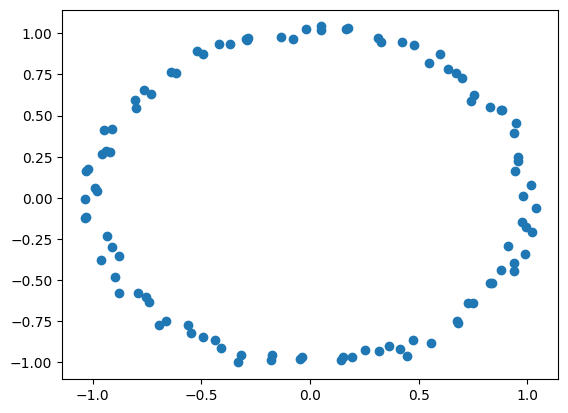

In [10]:
plt.scatter(samples[6][:, 0], samples[6][:, 1])
plt.show()

In [28]:
from google.colab import drive
from google.colab import files
drive.mount('/content/drive',force_remount=True)

import os
os.chdir("/content/drive/My Drive/Coding")

Mounted at /content/drive


In [29]:
pd0_union = []
pd1_union = []
pd0 = []
pd1 = []

PD_dict = {}
for i in np.arange(n_samples_per_shape*2):
    print ('Working on number {}'.format(i))
    p0, p1 = getPD(samples[i], 2)

    #PD_dict['PD{}'.format(i)] = np.vstack((np.column_stack((p0[0],p0[1])), np.column_stack((p1[0],p1[1]))))
    #np.savez('/content/drive/My Drive/Coding/PD{}'.format(i), PD_dict['PD{}'.format(i)])

    PD_dict['PD{} dim0'.format(i)] = np.column_stack((p0[0],p0[1]))
    PD_dict['PD{} dim1'.format(i)] = np.column_stack((p1[0],p1[1]))
    np.savez('/content/drive/My Drive/Coding/PD{} dim0'.format(i), PD_dict['PD{} dim0'.format(i)])
    np.savez('/content/drive/My Drive/Coding/PD{} dim1'.format(i), PD_dict['PD{} dim1'.format(i)])

    pd0_union.append(p0)
    pd1_union.append(p1)
    pd0.append(p0)
    pd1.append(p1)

Working on number 0
Working on number 1
Working on number 2
Working on number 3
Working on number 4
Working on number 5
Working on number 6
Working on number 7
Working on number 8
Working on number 9
Working on number 10
Working on number 11
Working on number 12
Working on number 13
Working on number 14
Working on number 15
Working on number 16
Working on number 17
Working on number 18
Working on number 19
Working on number 20
Working on number 21
Working on number 22
Working on number 23
Working on number 24
Working on number 25
Working on number 26
Working on number 27
Working on number 28
Working on number 29
Working on number 30
Working on number 31
Working on number 32
Working on number 33
Working on number 34
Working on number 35
Working on number 36
Working on number 37
Working on number 38
Working on number 39
Working on number 40
Working on number 41
Working on number 42
Working on number 43
Working on number 44
Working on number 45
Working on number 46
Working on number 47
Wo

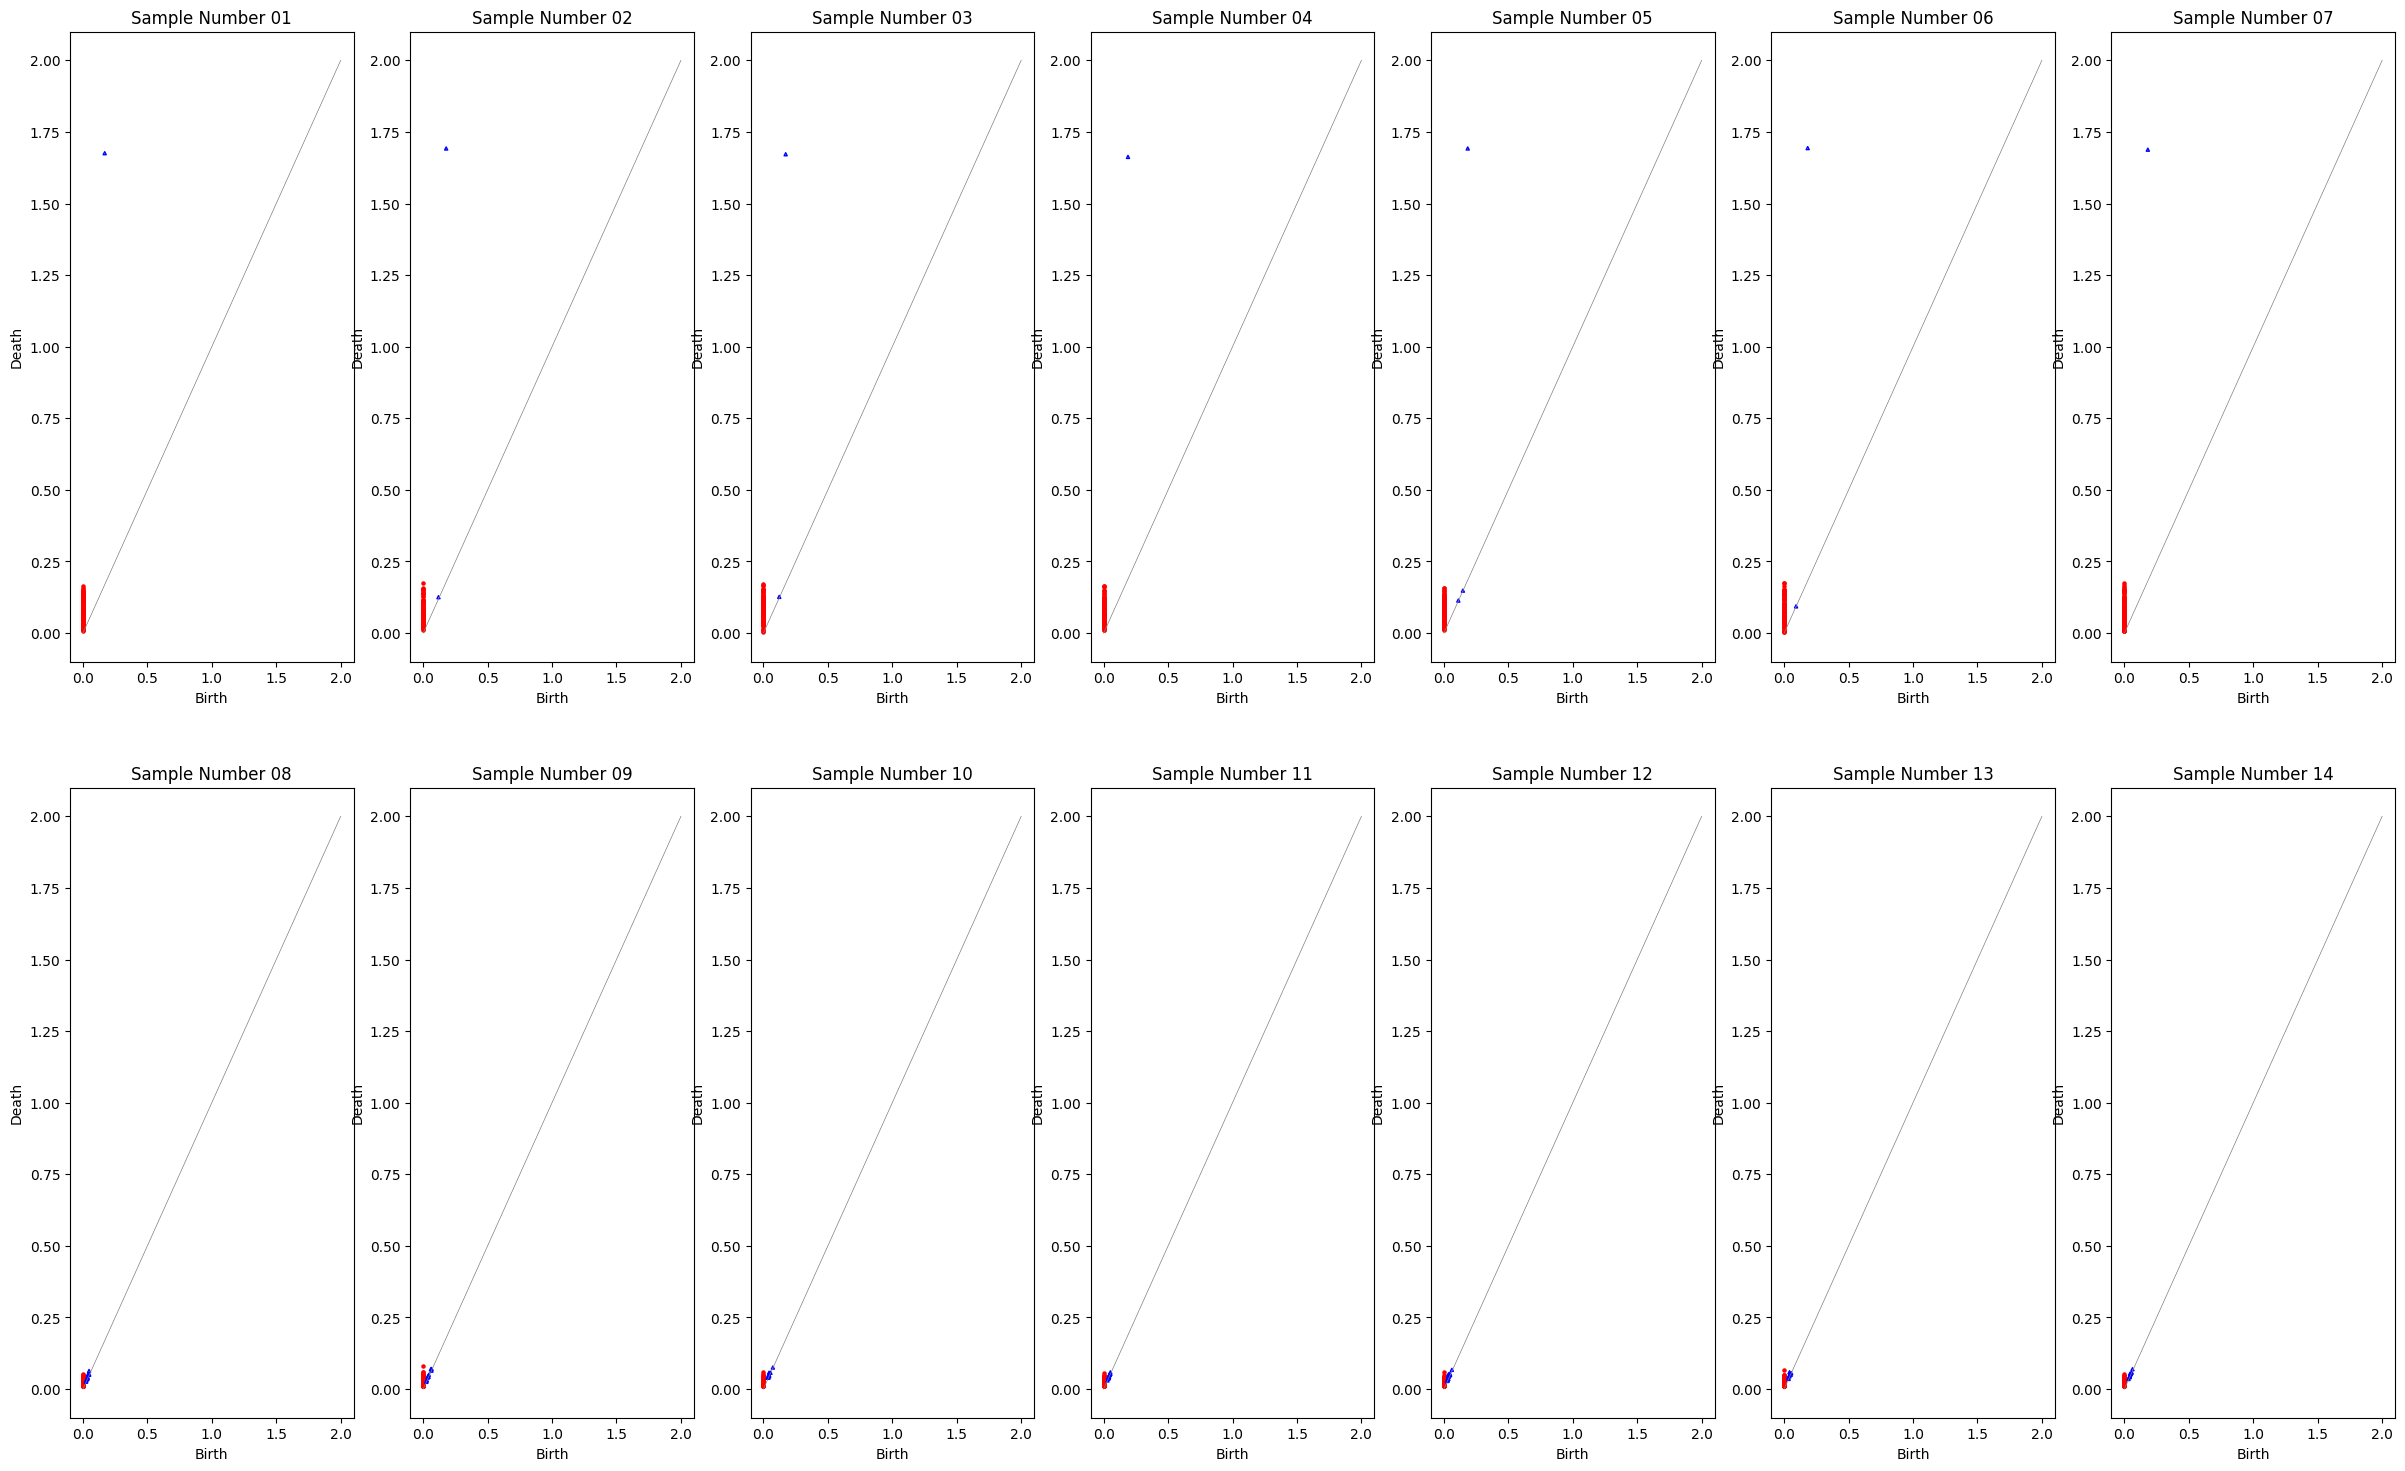

In [13]:
titles = ['Sample Number %02d' %(i+1) for i in np.arange(n_samples_per_shape*2)]
plot_Dionysus_PDs(pd0_union, pd1_union, titles)

In [30]:
wdist = np.zeros((n_samples_per_shape*2,n_samples_per_shape*2))
for i in range(n_samples_per_shape*2):
    xs= np.concatenate((pd0[i][0][:], pd1[i][0][:]), axis=0)
    ys= np.concatenate((pd0[i][1][:], pd1[i][1][:]), axis=0)
    Di = np.transpose([xs,ys])

    for j in range(i+1):
        #print(i,j)
        xs= np.concatenate((pd0[j][0][:], pd1[j][0][:]), axis=0)
        ys= np.concatenate((pd0[j][1][:], pd1[j][1][:]), axis=0)
        Dj = np.transpose([xs,ys])

        wdist[i,j] = wd(Di, Dj, order=2) #wasserstein(Di, Dj) # where the format of PD is numpy matrix
        wdist[j,i] = wdist[i,j]

wdist=(wdist-np.min(wdist))/(np.max(wdist)-np.min(wdist))

In [31]:
# Do cluster on PDs

kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(wdist)
kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

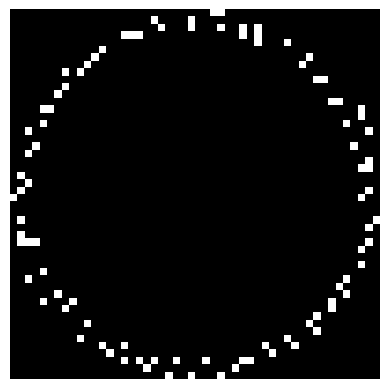

In [16]:
# Then we do cluster on vectorized data

binary_image1  = coordinates_to_image(samples[1][:, 0], samples[1][:, 1], image_size=(50, 50))
binary_image2  = coordinates_to_image(samples[2][:, 0], samples[2][:, 1], image_size=(50, 50))
plt.imshow(binary_image2, cmap='gray')
plt.axis('off')
plt.show()


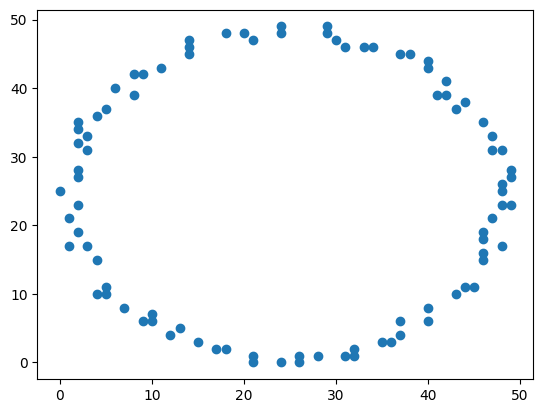

In [17]:
pointcloud = np.argwhere(binary_image1 == 1)
plt.scatter(pointcloud[:, 0], pointcloud[:, 1])
plt.show()

In [32]:
vectorList = []
for i in np.arange(n_samples_per_shape*2):
    temp = coordinates_to_image(samples[i][:, 0], samples[i][:, 1], image_size=(50, 50))
    vectorList.append(temp)

L2Dist = np.zeros((n_samples_per_shape*2,n_samples_per_shape*2))
for i in range(n_samples_per_shape*2):
    for j in range(i+1):
        L2Dist[i,j] = LA.norm(vectorList[i].reshape(1,2500)[0] - vectorList[j].reshape(1,2500)[0], 2)
        L2Dist[j,i] = L2Dist[i,j]

In [33]:
kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(L2Dist)
kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [ ]:
'''
# Experiment for 2-dim homology

def getPDdim2(data, r):
    f = d.fill_rips(np.array(data, dtype='float64'), 2, r)
    p = d.homology_persistence(f)
    dgms = d.init_diagrams(p, f)
    birth0 = [dgm.birth for dgm in dgms[0]]
    death0 = [dgm.death for dgm in dgms[0]]
    birth1 = [dgm.birth for dgm in dgms[1]]
    death1 = [dgm.death for dgm in dgms[1]]
    birth2 = [dgm.birth for dgm in dgms[2]]
    death2 = [dgm.death for dgm in dgms[2]]
    return [[birth0,death0],[birth1,death1], [birth2, death2]]

def plot_Dionysus_PDs_dim2(pd0_array, pd1_array, pd2_array, titles, lower_bound=240, upper_bound=300):
    fig = plt.figure(figsize=(30,18))
    nday = len(pd0_array)
    for iday in np.arange(nday):
        ax = fig.add_subplot(2,7,1+iday)
        ax.scatter(pd0_array[iday][0], pd0_array[iday][1], color='r', s=5, label = '0')
        ax.scatter(pd1_array[iday][0], pd1_array[iday][1], color='blue', s=5, label = '1')
        ax.scatter(pd1_array[iday][0], pd2_array[iday][1], color='blue', s=5, label = '2')

        ax.plot(np.arange(0, 3), np.arange(0, 3), '-', color='grey', lw=0.5)
        #ax.set_xlim([lower_bound, upper_bound])
        #ax.set_ylim([lower_bound, upper_bound])
        ax.set_title(titles[iday])
        ax.set_xlabel('Birth')
        ax.set_ylabel('Death')
    plt.savefig("pds.pdf",bbox_inches='tight')
    plt.show()
'''

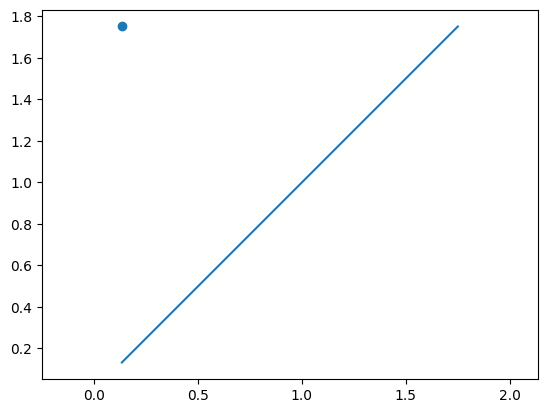

In [ ]:
'''
circle_point_clouds, sphere_point_clouds = make_point_clouds(n_samples_per_shape, n_points, 0)

f = d.fill_rips(np.array(circle_point_clouds[0], dtype='float64'), 2, 2)
p = d.homology_persistence(f)
dgms = d.init_diagrams(p, f)

#d.plot.plot_diagram(dgms[0])
d.plot.plot_diagram(dgms[1])
#d.plot.plot_diagram(dgms[2])

#plt.scatter(circle_point_clouds[0][:, 0], circle_point_clouds[0][:, 1])
#plt.show()
'''